In [7]:
import importlib
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.ops import math_ops

# Add parent directory to path to 
# allow imports of custom modules
if not '..' in sys.path:
    sys.path.append('..')
    
from models.losses import triplets
from utils.generic import progress_bar
from utils.data.gen import \
    get_toy_dataset, \
    create_triplets_from_augmentations, \
    create_class_triplets, \
    create_triplets_from_hierarchical_classes
from utils.data.preproc import add_random_noise

In [8]:
PROJECT_HOME = '../../'
VIS_PATH = PROJECT_HOME+'vis/'
DATA_PATH = '/mnt/e/Datasets/cifar10/hdf5/cifar10.hdf5'

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# Load Data

In [10]:
hdf5_file = h5py.File(DATA_PATH, 'r')

In [11]:
X = np.array(hdf5_file['train']['data'])
train_ids = np.array(hdf5_file['train']['ids'])
y = np.array(hdf5_file['train']['labels'])

In [12]:
X.shape

(50000, 32, 32, 3)

# Create Model

In [13]:
importlib.reload(triplets)

<module 'models.losses.triplets' from '../models/losses/triplets.py'>

In [118]:
_USE_TRIPLET_LOSS = True
_USE_CATEGORY_LOSS = False

In [119]:
inp_shape = X.shape[1:]
n_out_nodes = y.shape[1]

inp = keras.Input(shape=inp_shape)

x = layers.Conv2D(64, (3,3), padding='same', activation='linear', name='conv1_1')(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='linear', name='conv1_2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='linear', name='conv1_3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.AveragePooling2D()(x)

#x = layers.Conv2D(192, (3,3), padding='same', activation='linear', name='conv1b_1')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
#x = layers.Conv2D(192, (3,3), padding='same', activation='linear', name='conv1b_2')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)
#x = layers.Conv2D(192, (3,3), padding='same', activation='linear', name='conv1b_3')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Activation('relu')(x)

x = layers.Conv2D(192, (3,3), padding='same', activation='linear', name='conv2_1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(192, (1,1), padding='valid', activation='linear', name='conv2_2')(x)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(10, (1,1), padding='valid', activation='linear', name='conv2_3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

#logits = layers.GlobalAveragePooling2D(name='logits')(x)
#out = layers.Activation('softmax', name='cat')(logits)

emb = layers.Flatten(name='emb')(x)
out = layers.Dense(n_out_nodes, 'softmax', name='cat')(emb)

In [120]:
cat_loss = 'mse'
triplet_loss = triplets.OnlineTripletLoss(margin=1., squared=True)
optimizer = tf.keras.optimizers.Adam()

In [121]:
if _USE_TRIPLET_LOSS and _USE_CATEGORY_LOSS:
    model = keras.Model(inp, [out, emb])
    losses = {'cat':cat_loss, 'emb':triplet_loss}
    metrics = {'cat':'CategoricalAccuracy'}
elif _USE_TRIPLET_LOSS and not _USE_CATEGORY_LOSS:
    model = keras.Model(inp, emb)
    losses = triplet_loss
    metrics = []
elif not _USE_TRIPLET_LOSS and _USE_CATEGORY_LOSS:
    model = keras.Model(inp, out)
    losses = cat_loss
    metrics = ['CategoricalAccuracy']
else:
    ValueError('Enable one or both of triplet or category loss.')

model.compile(optimizer, losses, metrics)

In [122]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_78 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_74 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_75 (Activation)   (None, 32, 32, 64)        0  

In [123]:
history = model.fit(
    x=X, y=y, 
    epochs=12, 
    batch_size=256, 
    validation_split=0.2)

Epoch 1/12
157/157 [==============================] - 7s 44ms/step - loss: 2.3319 - val_loss: 0.6091
Epoch 2/12
157/157 [==============================] - 7s 43ms/step - loss: 0.3706 - val_loss: 0.4099
Epoch 3/12
157/157 [==============================] - 7s 44ms/step - loss: 0.3288 - val_loss: 0.3489
Epoch 4/12
157/157 [==============================] - 7s 44ms/step - loss: 0.3091 - val_loss: 0.3083
Epoch 5/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2971 - val_loss: 0.2988
Epoch 6/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2876 - val_loss: 0.2921
Epoch 7/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2789 - val_loss: 0.2818
Epoch 8/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2697 - val_loss: 0.2673
Epoch 9/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2602 - val_loss: 0.2600
Epoch 10/12
157/157 [==============================] - 7s 44ms/step - loss: 0.2526 - val_lo

In [125]:
# Create projection model
emb_model = keras.Model(model.input, model.get_layer('emb').output)

# Project data
feed_size = 10
myLen = 2000
embeddings = np.zeros((myLen, emb_model.output.shape[1]))
for i in range(0,myLen,feed_size):
    if i % 10 == 0: 
        print('Step {}\r'.format(i), end='')
    embeddings[i:i+feed_size] = emb_model(X[i:i+feed_size]).numpy()

Step 1980Step 1990

In [126]:
tsne_embeds = TSNE(n_components=2, verbose=1).fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.096s...
[t-SNE] Computed neighbors for 2000 samples in 4.027s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.385142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.742332
[t-SNE] KL divergence after 1000 iterations: 1.872344


In [127]:
# Translate one-hot encoded labels back to integers
dehot_y = tf.argmax(y, axis=1)

In [118]:
labels = tf.cast(labels, tf.float32)

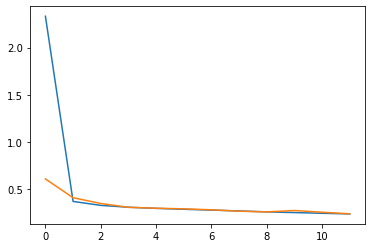

In [124]:
start = 0
end = None
plt.plot(history.history['loss'][start:end], label='train')
plt.plot(history.history['val_loss'][start:end], label='val')
plt.show()

## Visualize learned representations

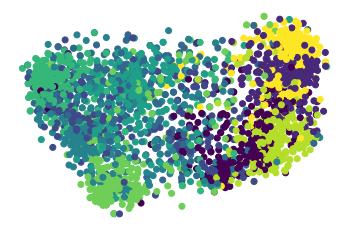

In [128]:
plt.axis('off')
plt.scatter(tsne_embeds[:,0], tsne_embeds[:,1], c=dehot_y[:myLen])
plt.show()